## MergeNet architecture

Multi-stage training with weight-sharing, learning separately the low and high-level features from RGBD input and fusing them in a refining stage.

Trained and evaluated on Lost and Found dataset.

Combining both appearance cues (RGB) and depth information performs better in identifying small obstacles and it is less sensitive to missinterpreting markings and zebra crossings as obstacles on the road (which could also cause a change in the image gradients) as obstacle edges.

MergeNet can be trained on small dataset (135 images) and still obtain promising results.

Contains 3 networks:
  - stripe-net: fully convolutional encoder-decoder trained with vertical strips of RGBD input
    - learns low-level features from vertical pathways of road images
    - shares parameters across stripes to reduce complexity and overfitting
  - context-net: also a fully convolutional encoder-decoder but trained on the whole image
    - learns high-level features from a wider region than a stripe-width
  - refiner-net: aggregate low- and high-level features and make the final prediction

The encoder & decoder blocks used for upsampling and downsampling the image is based on the Segnet network's architecture.
    - encoder: downsamples the input image through a series of convolutions, batch normalization and pooling layers
    - decoder: upsamples the encoded features through series of deconvolutions, batch normalization and unpooling layers until it re-obtains the original input resolution



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.10.1


In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


## Load dataset

In [3]:
[train_ds, valid_ds, test_ds], info = tfds.load(name="lost_and_found/full",
                                                split=['train[:90%]', 'train[90%:]', 'test'], with_info=True)

In [4]:
train_ds.element_spec

{'disparity_map': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'image_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'image_right': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'instance_id': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}

In [5]:
TRAIN_SIZE = train_ds.cardinality().numpy()
VALID_SIZE = valid_ds.cardinality().numpy()
TEST_SIZE = test_ds.cardinality().numpy()

print("Nr training instances = ", TRAIN_SIZE)
print("Nr validation instances = ", VALID_SIZE)
print("Nr test instances = ", TEST_SIZE)

Nr training instances =  932
Nr validation instances =  104
Nr test instances =  1203


In [6]:
BATCH_SIZE = 4
BATCH_SIZE_STRIPE = 32
NR_CLASSES = 3
ORIG_HEIGHT = 1024
ORIG_WIDTH = 2048
IMG_HEIGHT = 256
IMG_WIDTH = 896
K = 28

In [7]:
def preprocess_input(dataset, batch_size, buffer_size, reshuffle=False):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=reshuffle)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    # todo: add data augmentation
    dataset = dataset.prefetch(batch_size)
    return dataset


def process_images(x, img_shape):
    x = tf.image.resize(x, img_shape)
    # result of resizing will be a float tensor
    x = x / 255.0
    return x


def encode_label(x):
    x = tf.math.minimum(x, [2])
    return x


def process_labels(x, img_shape):
    x = tf.image.resize(x, img_shape, method='nearest')
    x = tf.map_fn(encode_label, x)
    return x


def process_img_stripes(x, img_shape, k):
    x = process_images(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x


def process_label_stripes(x, img_shape, k):
    x = process_labels(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x


def prepare_images(ds, img_shape):
    input = ds.map(lambda x: (x['image_left'], x['segmentation_label']))
    input = input.map(lambda x, y: (process_images(x, img_shape=img_shape),
                                    process_labels(y, img_shape=img_shape)))
    return input


def prepare_mixed(ds, img_shape, k):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.map(lambda x, y, z: (process_images(x, img_shape=img_shape),
                                       process_images(y, img_shape=img_shape),
                                       process_labels(z, img_shape=img_shape)))
    input = input.map(lambda x, y, z: ((x, y), z))
    return input


def prepare_stripes(ds, img_shape, k):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.flat_map(
        lambda x, y, z: tf.data.Dataset.from_tensor_slices(((process_img_stripes(x, img_shape=img_shape, k=k),
                                                             process_img_stripes(y, img_shape=img_shape, k=k),
                                                             process_label_stripes(z, img_shape=img_shape, k=k)))))
    input = input.map(lambda x, y, z: ((x, y), z))
    return input

In [8]:
train_stripes = prepare_stripes(train_ds, [IMG_HEIGHT, IMG_WIDTH], K)
valid_stripes = prepare_stripes(valid_ds, [IMG_HEIGHT, IMG_WIDTH], K)
test_stripes = prepare_stripes(test_ds, [IMG_HEIGHT, IMG_WIDTH], K)

train_img = prepare_images(train_ds, [IMG_HEIGHT, IMG_WIDTH])
valid_img = prepare_images(valid_ds, [IMG_HEIGHT, IMG_WIDTH])
test_img = prepare_images(test_ds, [IMG_HEIGHT, IMG_WIDTH])

train_mix = prepare_mixed(train_ds, [IMG_HEIGHT, IMG_WIDTH], K)
valid_mix = prepare_mixed(valid_ds, [IMG_HEIGHT, IMG_WIDTH], K)
test_mix = prepare_mixed(test_ds, [IMG_HEIGHT, IMG_WIDTH], K)

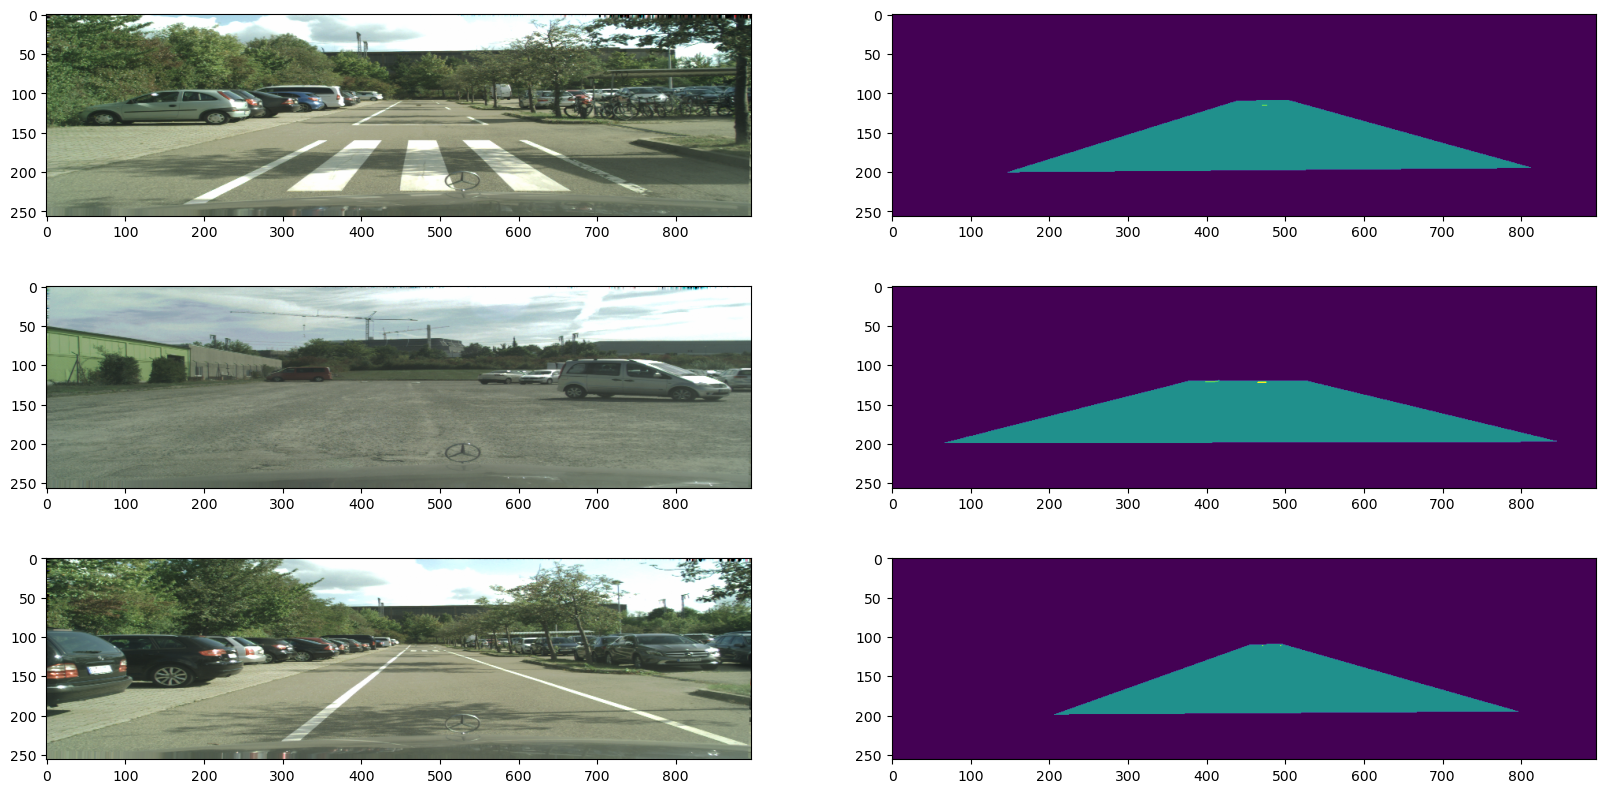

In [9]:
nr_samples = 3
fig, arr = plt.subplots(nr_samples, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
i = 0
for img, label in train_img.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(label)
    i += 1
    if i >= nr_samples:
        break

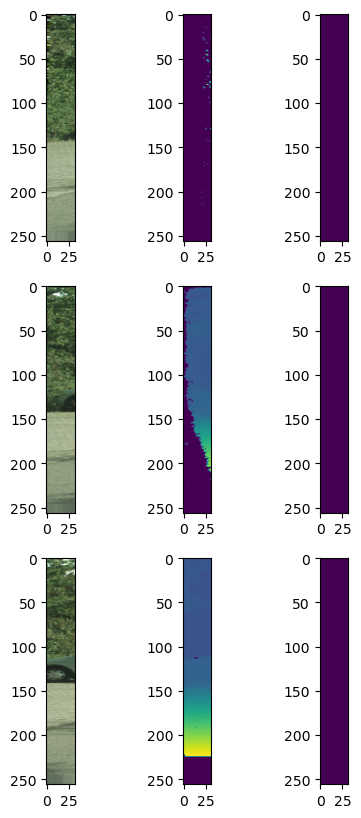

In [10]:
nr_samples = 3
fig, arr = plt.subplots(3, nr_samples)
fig.set_figheight(10)
fig.set_figwidth(5)
i = 0
for (img, depth), label in train_stripes.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(depth)
    arr[i, 2].imshow(label)
    i += 1
    if i >= nr_samples:
        break

## Build the models

In [11]:
def conv_layer(input, filters=64, kernel=(3, 3), activation_fct="relu"):
    conv = layers.Conv2D(filters, kernel, padding="same", input_shape=input.shape[1:])(input)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation_fct)(conv)
    return conv


def encoder_decoder(input_shape,
                    filters,
                    kernel=(3, 3),
                    pool_size=(2, 2)):
    inputs = layers.Input(shape=input_shape)

    # encoder: 4 convolutional layers
    conv_1 = conv_layer(input=inputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    conv_3 = conv_layer(input=pool_2, filters=filters * 4, kernel=kernel, activation_fct="relu")
    pool_3 = layers.MaxPooling2D(pool_size)(conv_3)

    conv_4 = conv_layer(input=pool_3, filters=filters * 8, kernel=kernel, activation_fct="relu")
    pool_4 = layers.MaxPooling2D(pool_size)(conv_4)

    # decoder: 4 convolutional layers
    unpool_1 = layers.UpSampling2D(pool_size)(pool_4)
    conv_5 = conv_layer(input=unpool_1, filters=filters * 8, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_5)
    conv_6 = conv_layer(input=unpool_2, filters=filters * 4, kernel=kernel, activation_fct="relu")

    unpool_3 = layers.UpSampling2D(pool_size)(conv_6)
    conv_7 = conv_layer(input=unpool_3, filters=filters * 2, kernel=kernel, activation_fct="relu")

    unpool_4 = layers.UpSampling2D(pool_size)(conv_7)
    conv_8 = conv_layer(input=unpool_4, filters=filters, kernel=kernel, activation_fct="relu")

    model = keras.Model(inputs=inputs, outputs=conv_8)
    return model

In [12]:
def build_stripe_net(rgb_input_shape, depth_input_shape, nr_classes, k):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=k // 4, kernel=(3, 3), pool_size=(2, 2))
    depth_enc_dec = encoder_decoder(input_shape=depth_input_shape, filters=k // 4, kernel=(3, 3), pool_size=(2, 2))
    concatenated = layers.Concatenate()([rgb_enc_dec.output, depth_enc_dec.output])
    output = layers.Conv2D(filters=nr_classes, kernel_size=(1, 1), padding="same", activation="softmax")(concatenated)
    model = keras.Model(inputs=[rgb_enc_dec.input, depth_enc_dec.input], outputs=output, name='stripe_net')
    return model

In [13]:
def build_context_net(rgb_input_shape, nr_classes):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=8, kernel=(3, 3), pool_size=(2, 2))
    final_conv = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same")(
        rgb_enc_dec.output)
    model = keras.Model(inputs=rgb_enc_dec.input, outputs=final_conv, name='context_net')
    return model

In [14]:
def build_refiner_net(rgb_input_shape, depth_input_shape, nr_stripes, nr_classes, filters=8, kernel=(3, 3), pool_size=(2, 2)):
    stripe_model = keras.models.load_model("models/stripe_net.h5")
    context_model = keras.models.load_model("models/context_net.h5")
    # freeze the weights of the outer models
    stripe_model.trainable = False
    context_model.trainable = False

    rgb_inputs = layers.Input(shape=rgb_input_shape)
    depth_inputs = layers.Input(shape=depth_input_shape)

    stripe_inputs = layers.Lambda(
        lambda x: [(a, b) for a, b in zip(tf.split(x[0], nr_stripes, axis=2), (tf.split(x[1], nr_stripes, axis=2)))])(
        [rgb_inputs, depth_inputs])

    stripe_outputs = [stripe_model(si) for si in stripe_inputs]
    stripe_output = layers.Concatenate(axis=2)(stripe_outputs)

    context_output = context_model(rgb_inputs)

    partial_outputs = layers.Concatenate(axis=-1)([stripe_output, context_output])
    partial_outputs = layers.Conv2D(filters=3, kernel_size=(1, 1))(partial_outputs)

    conv_1 = conv_layer(input=partial_outputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    unpool_1 = layers.UpSampling2D(pool_size)(pool_2)
    conv_3 = conv_layer(input=unpool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_3)
    conv_4 = conv_layer(input=unpool_2, filters=filters, kernel=kernel, activation_fct="relu")

    output = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same", name="final_conv")(
        conv_4)

    model = keras.Model(inputs=[rgb_inputs, depth_inputs], outputs=output, name='refiner_net')
    return model

In [15]:
def add_argmax_layer(model):
    argmax_output = layers.Lambda(lambda x: tf.expand_dims(tf.cast(tf.math.argmax(x, axis=-1), 'uint8'), axis=-1))(
        model.output)

    enhanced_model = keras.Model(inputs=model.input, outputs=argmax_output, name='merge_net')
    return enhanced_model

## Train the models

In [16]:
def plot_history(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Stripe-net

In [14]:
BATCH_SIZE_STRIPE = 32
train_stripes_batch = preprocess_input(train_stripes, BATCH_SIZE_STRIPE, buffer_size=TRAIN_SIZE, reshuffle=True)
valid_stripes_batch = preprocess_input(valid_stripes, BATCH_SIZE_STRIPE, buffer_size=VALID_SIZE, reshuffle=True)

In [24]:
stripe_net_model = build_stripe_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH // K, 3),
                                    depth_input_shape=(IMG_HEIGHT, IMG_WIDTH // K, 1),
                                    nr_classes=NR_CLASSES,
                                    k=K)
print(stripe_net_model.summary())

Model: "stripe_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 32, 7)   196         ['input_3[0][0]']                
                                                                                         

In [56]:
stripe_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [57]:
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("models/stripe_net.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 30

stripe_net_history = stripe_net_model.fit(train_stripes_batch,
                                          batch_size=BATCH_SIZE_STRIPE,
                                          epochs=EPOCHS,
                                          shuffle=True,
                                          steps_per_epoch=TRAIN_SIZE * K // BATCH_SIZE_STRIPE,
                                          validation_steps=VALID_SIZE * K // BATCH_SIZE_STRIPE,
                                          callbacks=[earlystopper, reduce_lr, checkpoint],
                                          validation_data=valid_stripes_batch)

Epoch 1/30
814/815 [============================>.] - ETA: 0s - loss: 0.0755 - sparse_categorical_accuracy: 0.9697
Epoch 1: val_loss improved from inf to 0.22926, saving model to models\stripe_net.h5
815/815 [==============================] - 27s 31ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9147 - lr: 0.0100
Epoch 2/30
815/815 [==============================] - ETA: 0s - loss: 0.0683 - sparse_categorical_accuracy: 0.9723
Epoch 2: val_loss did not improve from 0.22926
815/815 [==============================] - 24s 30ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.7388 - val_sparse_categorical_accuracy: 0.8666 - lr: 0.0100
Epoch 3/30
814/815 [============================>.] - ETA: 0s - loss: 0.0655 - sparse_categorical_accuracy: 0.9735
Epoch 3: val_loss did not improve from 0.22926
815/815 [==============================] - 24s 30ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.973

In [58]:
print(stripe_net_history.history.key())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


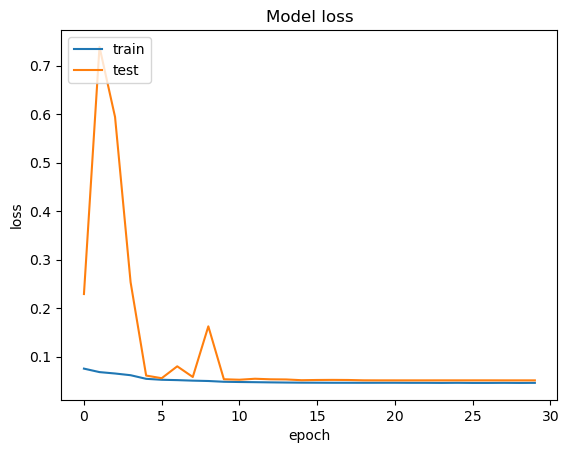

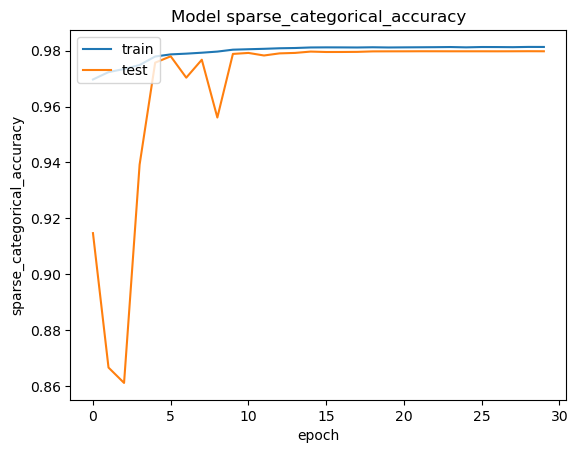

In [59]:
plot_history(stripe_net_history.history, 'loss')
plot_history(stripe_net_history.history, 'sparse_categorical_accuracy')

In [60]:
test_stripes_batch = test_stripes.batch(BATCH_SIZE_STRIPE)
stripe_net_score = stripe_net_model.evaluate(test_stripes_batch)

1053/1053 [==============================] - 50s 47ms/step - loss: 0.1618 - sparse_categorical_accuracy: 0.9452


In [61]:
print("Stripe-net: loss=", stripe_net_score[0], ", accuracy=", stripe_net_score[1])

Stripe-net: loss= 0.16177044808864594 , accuracy= 0.9452133178710938


1/1 [==============================] - 0s 493ms/step


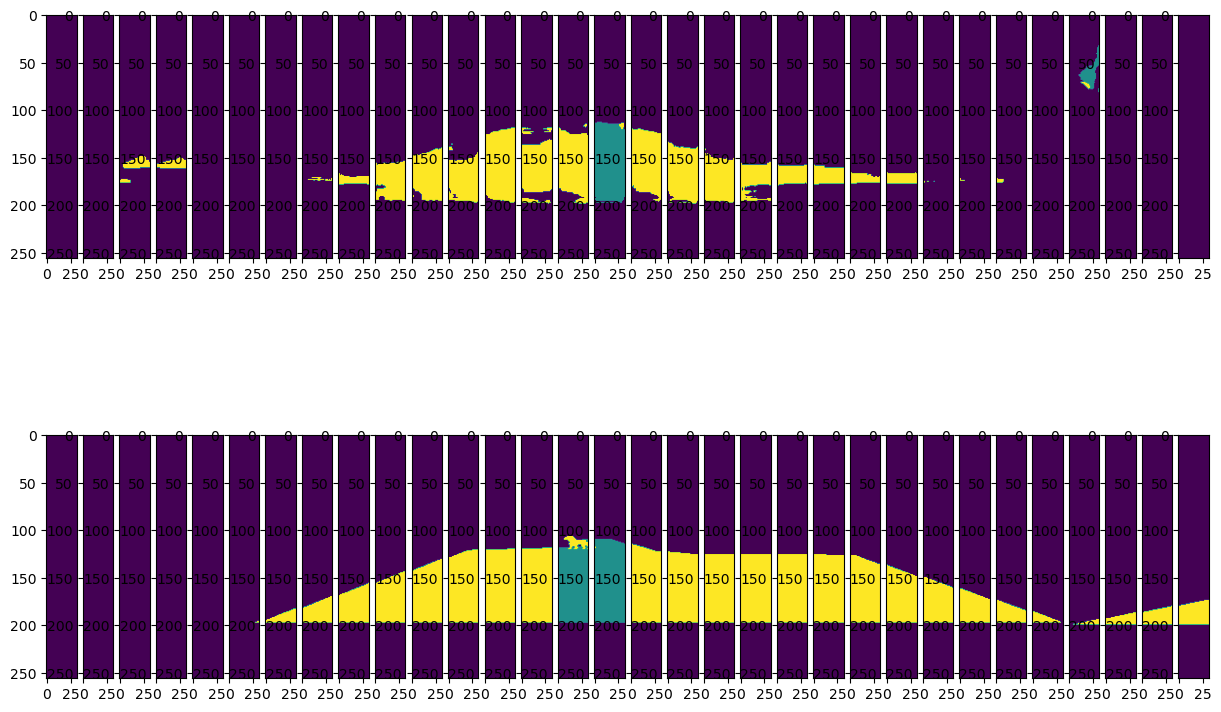

In [65]:
nr_samples = BATCH_SIZE_STRIPE
for x, label in test_stripes_batch.as_numpy_iterator():
    pred_mask = stripe_net_model.predict(x)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(2, nr_samples)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    for i in range(nr_samples):
        arr[0, i].imshow(pred_mask[i])
        arr[1, i].imshow(label[i])
    break

### Context-net

In [18]:
def count_pixels(x, label):
    x = x.flatten()
    return np.sum([x == label])


def compute_class_weights(ds, batch_size):
    for _, mask in ds.as_numpy_iterator():
        nr_background_pixels = count_pixels(mask, 0)
        nr_road_pixels = count_pixels(mask, 1)
        nr_obstacle_pixels = count_pixels(mask, 2)
        print("background : road : obstacle =", nr_background_pixels, ":", nr_road_pixels, ":", nr_obstacle_pixels)
        total_pixels = nr_background_pixels + nr_road_pixels + nr_obstacle_pixels
        # class weights are inversely proportional with the ratio of pixels of given class vs total pixels
        weights = [total_pixels / nr_background_pixels, total_pixels / nr_road_pixels,
                   total_pixels / nr_obstacle_pixels]
        weights = np.asarray(weights) / (batch_size*NR_CLASSES)
        return weights

In [19]:
BATCH_SIZE = 4

In [20]:
train_img_batch = preprocess_input(train_img, BATCH_SIZE, buffer_size=TRAIN_SIZE)
valid_img_batch = preprocess_input(valid_img, BATCH_SIZE, buffer_size=VALID_SIZE)

In [21]:
class_weights = compute_class_weights(train_img_batch, BATCH_SIZE)
print("Class weights on training batch:", class_weights)

background : road : obstacle = 760337 : 156610 : 557
Class weights on training batch: [1.00558919e-01 4.88210629e-01 1.37268701e+02]


In [66]:
context_net_model = build_context_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                      nr_classes=NR_CLASSES)
print(context_net_model.summary())

Model: "context_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 896, 3)]     0         
                                                                 
 conv2d_43 (Conv2D)          (None, 256, 896, 8)       224       
                                                                 
 batch_normalization_40 (Bat  (None, 256, 896, 8)      32        
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 256, 896, 8)       0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 128, 448, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 128, 448, 16)      

In [68]:
context_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          loss_weights=class_weights,
                          weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [69]:
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("models/context_net.h5", monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')
EPOCHS = 30

context_net_history = context_net_model.fit(train_img_batch,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
                                            callbacks=[earlystopper, reduce_lr, checkpoint],
                                            validation_steps=VALID_SIZE // BATCH_SIZE,
                                            validation_data=valid_img_batch)

Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 38.3602 - sparse_categorical_accuracy: 0.8933 - weighted_sparse_categorical_accuracy: 0.8933
Epoch 1: val_loss improved from inf to 81.95675, saving model to models\context_net.h5
233/233 [==============================] - 14s 55ms/step - loss: 38.3602 - sparse_categorical_accuracy: 0.8933 - weighted_sparse_categorical_accuracy: 0.8933 - val_loss: 81.9567 - val_sparse_categorical_accuracy: 0.8272 - val_weighted_sparse_categorical_accuracy: 0.8272 - lr: 0.0100
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 26.6457 - sparse_categorical_accuracy: 0.9304 - weighted_sparse_categorical_accuracy: 0.9304
Epoch 2: val_loss did not improve from 81.95675
233/233 [==============================] - 13s 54ms/step - loss: 26.6457 - sparse_categorical_accuracy: 0.9304 - weighted_sparse_categorical_accuracy: 0.9304 - val_loss: 178.0682 - val_sparse_categorical_accuracy: 0.8400 - val_weighted_sparse_categorical_

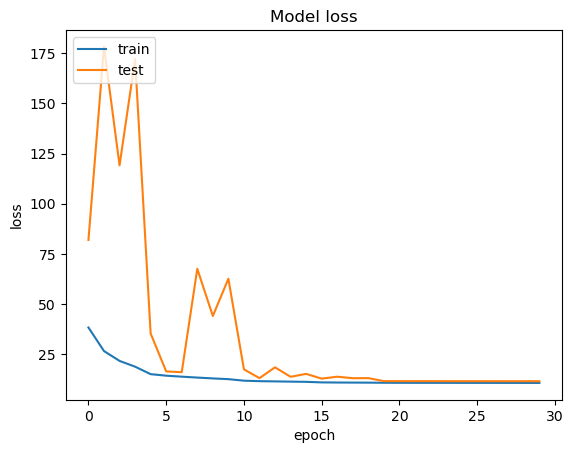

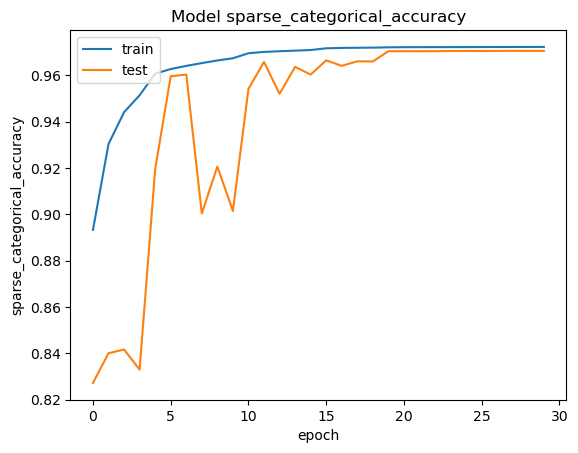

In [70]:
plot_history(context_net_history.history, 'loss')
plot_history(context_net_history.history, 'sparse_categorical_accuracy')

In [71]:
test_img_batch = test_img.batch(BATCH_SIZE)
context_net_scores = context_net_model.evaluate(test_img_batch)

301/301 [==============================] - 47s 154ms/step - loss: 32.6098 - sparse_categorical_accuracy: 0.9300 - weighted_sparse_categorical_accuracy: 0.9300


In [72]:
print("Stripe-net: loss=", context_net_scores[0], ", accuracy=", context_net_scores[1], ", weighted accuracy=", context_net_scores[2])

Stripe-net: loss= 32.609806060791016 , accuracy= 0.9300087094306946 , weighted accuracy= 0.9300087094306946


1/1 [==============================] - 0s 251ms/step


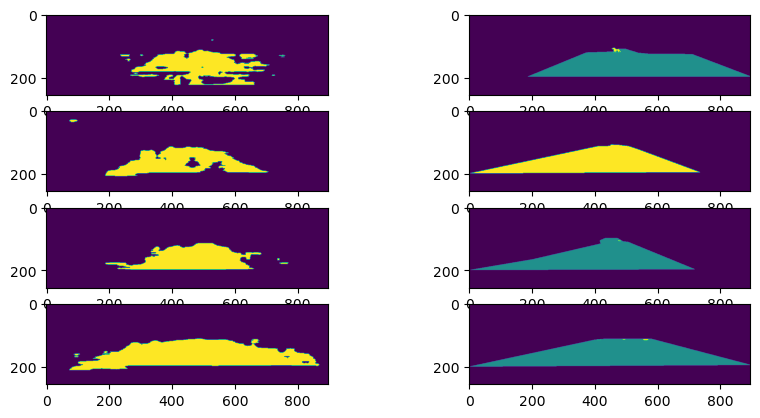

In [73]:
nr_samples = 4
for x, label in test_img_batch.as_numpy_iterator():
    pred_mask = context_net_model.predict(x)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(nr_samples, 2)
    fig.set_figwidth(10)
    for i in range(nr_samples):
        arr[i, 0].imshow(pred_mask[i])
        arr[i, 1].imshow(label[i])
    break

## Refiner-net

In [22]:
BATCH_SIZE = 4
train_input_mix = preprocess_input(train_mix, batch_size=BATCH_SIZE, buffer_size=TRAIN_SIZE)
valid_input_mix = preprocess_input(valid_mix, batch_size=BATCH_SIZE, buffer_size=VALID_SIZE)
train_input_mix.element_spec

((TensorSpec(shape=(None, 256, 896, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 896, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 256, 896, 1), dtype=tf.uint8, name=None))

In [38]:
refiner_net_model = build_refiner_net(rgb_input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
                                      depth_input_shape=[IMG_HEIGHT, IMG_WIDTH, 1],
                                      nr_stripes=K,
                                      nr_classes=NR_CLASSES)

In [24]:
print("Input shape:", refiner_net_model.input_shape)
print("Output shape:", refiner_net_model.output_shape)

Input shape: [(None, 256, 896, 3), (None, 256, 896, 1)]
Output shape: (None, 256, 896, 3)


In [39]:
refiner_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          loss_weights=class_weights,
                          weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [40]:
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("models/refiner_net.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 20

refiner_net_history = refiner_net_model.fit(train_input_mix,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
                                            callbacks=[earlystopper, reduce_lr, checkpoint],
                                            validation_steps=VALID_SIZE // BATCH_SIZE,
                                            validation_data=valid_input_mix)

Epoch 1/20
233/233 [==============================] - ETA: 0s - loss: 2.8925 - sparse_categorical_accuracy: 0.9783 - weighted_sparse_categorical_accuracy: 0.9783
Epoch 1: val_loss improved from inf to 2.64620, saving model to models\refiner_net.h5
233/233 [==============================] - 54s 166ms/step - loss: 2.8925 - sparse_categorical_accuracy: 0.9783 - weighted_sparse_categorical_accuracy: 0.9783 - val_loss: 2.6462 - val_sparse_categorical_accuracy: 0.9806 - val_weighted_sparse_categorical_accuracy: 0.9806 - lr: 0.0100
Epoch 2/20
233/233 [==============================] - ETA: 0s - loss: 2.0512 - sparse_categorical_accuracy: 0.9823 - weighted_sparse_categorical_accuracy: 0.9823
Epoch 2: val_loss improved from 2.64620 to 2.60938, saving model to models\refiner_net.h5
233/233 [==============================] - 32s 139ms/step - loss: 2.0512 - sparse_categorical_accuracy: 0.9823 - weighted_sparse_categorical_accuracy: 0.9823 - val_loss: 2.6094 - val_sparse_categorical_accuracy: 0.980

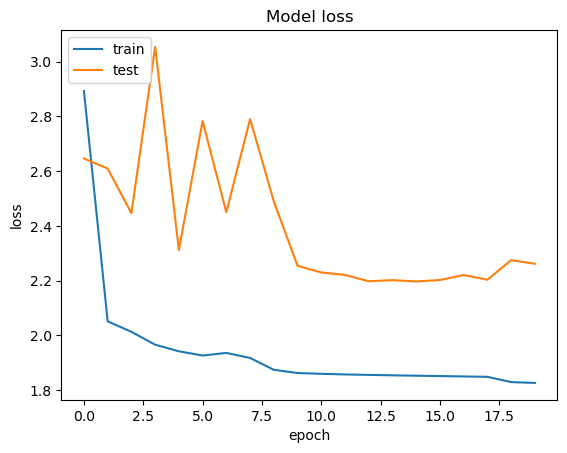

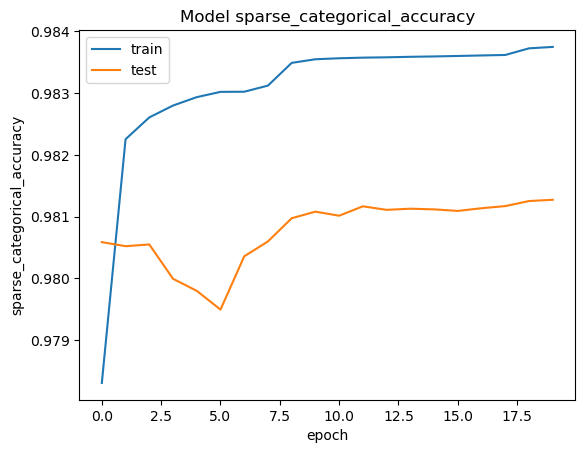

In [41]:
plot_history(refiner_net_history.history, 'loss')
plot_history(refiner_net_history.history, 'sparse_categorical_accuracy')

In [42]:
refiner_net_model.save_weights('models/refiner_net_weights.h5')

In [43]:
test_mix_batch = test_mix.batch(BATCH_SIZE)
refiner_net_scores = refiner_net_model.evaluate(test_mix_batch)

301/301 [==============================] - 50s 164ms/step - loss: 7.1896 - sparse_categorical_accuracy: 0.9457 - weighted_sparse_categorical_accuracy: 0.9457


In [44]:
print("Refiner-net: loss=", refiner_net_scores[0], ", accuracy=", refiner_net_scores[1], ", weighted accuracy=", refiner_net_scores[2])

Refiner-net: loss= 7.189647197723389 , accuracy= 0.9456867575645447 , weighted accuracy= 0.9456867575645447


In [45]:
merge_net_model = add_argmax_layer(refiner_net_model)

1/1 [==============================] - 7s 7s/step


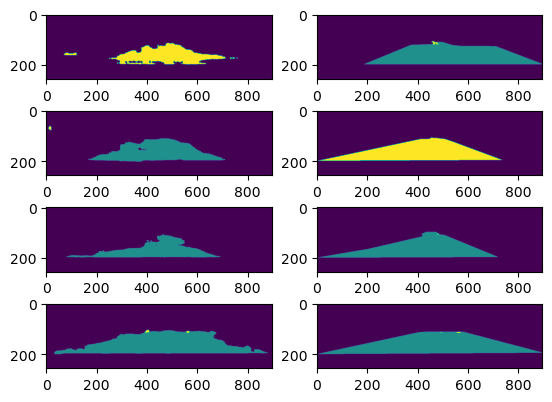

In [46]:
for x, y in test_mix_batch.as_numpy_iterator():
    pred_mask = merge_net_model.predict(x)
    fig, arr = plt.subplots(BATCH_SIZE, 2)
    for i in range(BATCH_SIZE):
        arr[i, 0].imshow(pred_mask[i])
        arr[i, 1].imshow(y[i])
    break

### Evaluate models

In [77]:
def prob_to_label(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = tf.cast(pred_mask, 'uint8')
    pred_mask = tf.one_hot(indices=pred_mask, depth=3, axis=-1)
    pred_mask = tf.squeeze(pred_mask, axis=-2)
    pred_mask = tf.reverse(pred_mask, axis=[-1])
    return (pred_mask+1.0)/2

def display_predicted_masks(img, stripe_output, context_output, refine_output):
    fig, arr = plt.subplots(BATCH_SIZE, 4)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    for i in range(BATCH_SIZE):
        arr[i, 0].set_title('Input image')
        arr[i, 0].imshow(img[i])
        arr[i, 1].set_title('Stripe-net output')
        arr[i, 1].imshow(np.multiply(img[i], prob_to_label(stripe_output[i])))
        arr[i, 2].set_title('Context-net output')
        arr[i, 2].imshow(np.multiply(img[i], prob_to_label(context_output[i])))
        arr[i, 3].set_title('Refiner-net output')
        arr[i, 3].imshow(np.multiply(img[i], prob_to_label(refine_output[i])))

In [48]:
stripe_net_model = keras.models.load_model("models/stripe_net.h5")
context_net_model = keras.models.load_model("models/context_net.h5")

In [50]:
# refiner net cannot be loaded directly because it contains a lambda layer
refiner_net_model = build_refiner_net(rgb_input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
                                      depth_input_shape=[IMG_HEIGHT, IMG_WIDTH, 1],
                                      nr_stripes=K,
                                      nr_classes=NR_CLASSES)
refiner_net_model.load_weights('models/refiner_net_weights.h5')
refiner_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          loss_weights=class_weights,
                          weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

1/1 [==============================] - 0s 352ms/step


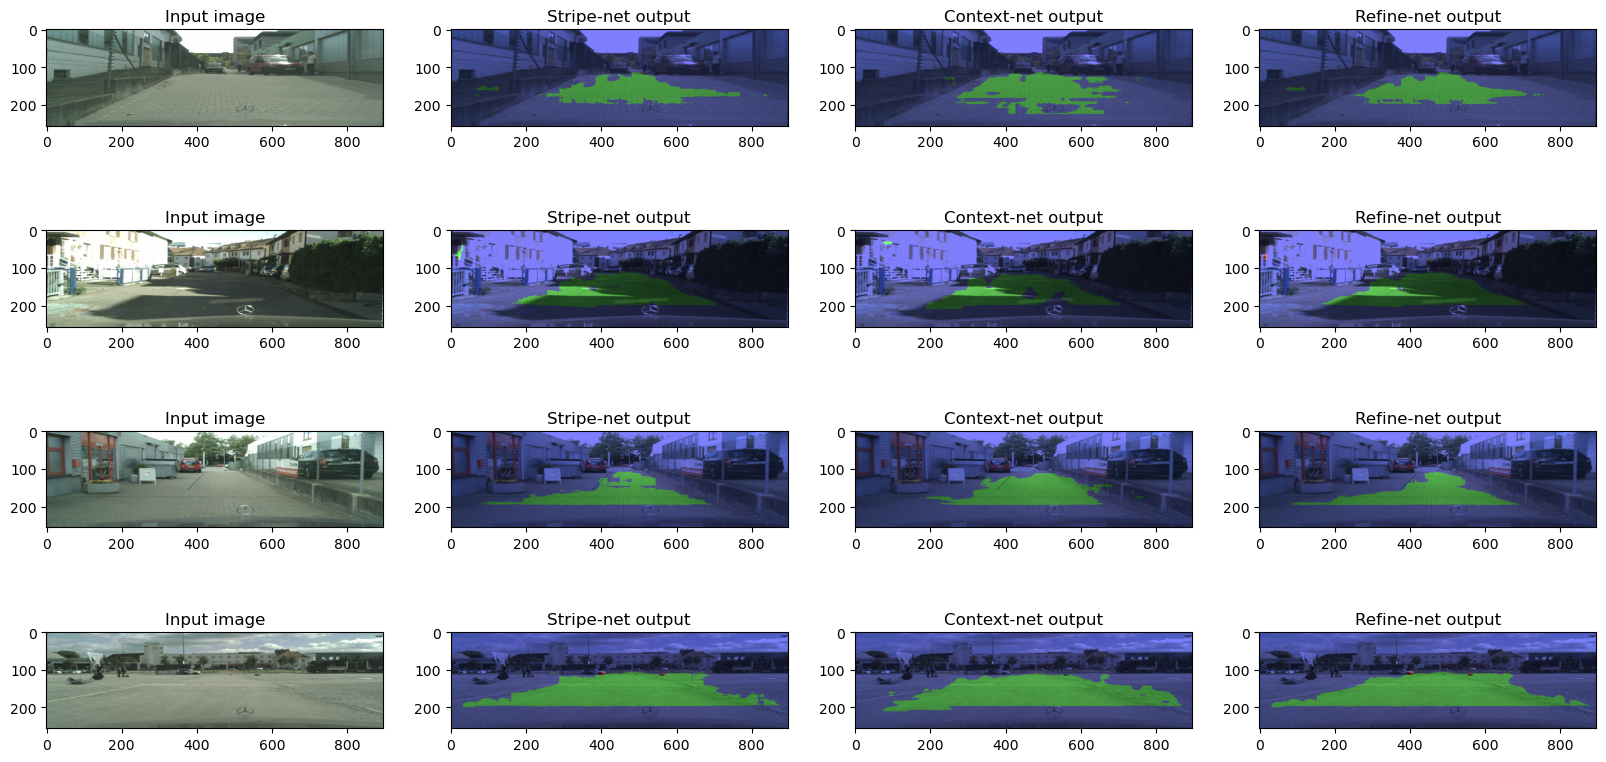

In [78]:
for rgbd, masks in test_mix_batch.as_numpy_iterator():
    pred_stripes=[]
    for i in range(BATCH_SIZE):
        rgbd_stripes = tf.data.Dataset.from_tensors((tf.split(rgbd[0][i], K, axis=1), tf.split(rgbd[1][i], K, axis=1), tf.split(masks[i], K, axis=1)))
        rgbd_stripes = rgbd_stripes.map(lambda x, y, z: ((x, y), z))
        pred = stripe_net_model.predict(rgbd_stripes.take(1))
        whole_img = tf.concat(list(pred), 1)
        pred_stripes.append(whole_img)

    pred_context = context_net_model.predict(rgbd[0])
    pred_refiner = refiner_net_model.predict(rgbd)
    display_predicted_masks(rgbd[0], pred_stripes, pred_context, pred_refiner)
    break

In [92]:
def count_pixels(mask, pred_mask):
    dims = pred_mask.shape[-1]
    if dims > 1:
        # convert prob distr to corresponding label
        pred_mask = tf.expand_dims(tf.math.argmax(pred_mask, axis=-1), axis=-1)

    # TN = total pixels of non-obstacle class
    tn = tf.math.count_nonzero(tf.subtract(mask, 2))
    # TP = total pixels of obstacle class
    tp = tf.reduce_prod(pred_mask.shape) - tn
    # IDP = incorrectly detected pixels
    idp = tf.reduce_sum(tf.abs(tf.subtract(mask, pred_mask)))

    return tp, idp

def calculate_pixel_wise_metrics(pred_ds):
    pixel_stats = pred_ds.map(lambda y_true, y_pred: count_pixels(y_true, y_pred))
    pixel_stats = tf.reduce_sum(pixel_stats, axis=1)
    tp = pixel_stats.map[0]
    idp = total_counts[1]

    # CDP = correctly detected pixels
    cdp = tp-idp
    # PDR = pixel-wise detection rate
    pdr = cdp/tp
    # PFPR = pixel-wise false positives rate
    pfpr = idp/tp
    return {'pdr':pdr, 'pfpr':pfpr}

def classify_instance(mask, pred_mask):
    # compute the binary mask (obs (1)/non-obstacle (0))
    bin_mask = tf.math.maximum(tf.math.subtract(pred_mask, 1), tf.constant([0]))

    # convert the mask to an instance-level map using a connected component algorithm
    connected_components = tfa.image.connected_components(img)

    overlay = tf.reshape(tf.multiply(bin_mask, connected_components), [-1])
    pred_instance_labels, pred_indices, pred_histogram = tf.unique_with_counts(overlay)
    true_instance_labels, true_indices, true_histogram = tf.unique_with_counts(mask)

    common_pixels = tf.size(tf.sets.intersection(pred_indices, true_indices))
    true_obs_pixels = tf.size(true_indices)

    return 1 if common_pixels > true_obs_pixels/2.0 else 0

def calculate_instance_wise_metrics(pred_ds):


SyntaxError: invalid syntax (1112663386.py, line 45)

In [ ]:
stripe_net_score = stripe_net_model.evaluate(test_stripes)